In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Confusion matrix generation
def get_clf_eval(y_test,pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred, average = 'macro')
    recall = recall_score(y_test,pred, average = 'macro')
    f1 = f1_score(y_test, pred, average = 'macro')
    roc_auc = roc_auc_score(y_test, pred_proba, average = 'macro', multi_class='ovr')
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 1. Load train and test data

In [4]:
train_data = pd.read_csv("data/train_data_PCA.csv", header=None)
test_data = pd.read_csv("data/test_data_PCA.csv", header=None)

X_train = train_data.iloc[:,:2]
y_train = train_data.iloc[:,2]

X_test = test_data.iloc[:,:2]
y_test = test_data.iloc[:,2]

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

### 2. Training random forest model

In [5]:
# Grid search for determining optimal paramters
param = {'n_estimators':[20, 40, 60, 80, 100],
         'max_depth':[4, 6, 8, 10, 12],
         'min_samples_leaf':[6, 8, 12, 18],
         'min_samples_split':[8, 16, 20]}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=param, cv=5, n_jobs=-1)
grid_cv.fit(X_train_scaled, y_train)

scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 
           'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'max_depth': 4, 'min_samples_leaf': 6, 'min_s...",0.885000,287,0.873611,0.881944,0.883333,0.895139,0.890972
1,"{'max_depth': 4, 'min_samples_leaf': 6, 'min_s...",0.885556,278,0.877778,0.876389,0.884722,0.897222,0.891667
2,"{'max_depth': 4, 'min_samples_leaf': 6, 'min_s...",0.884306,297,0.873611,0.875000,0.886806,0.893750,0.892361
3,"{'max_depth': 4, 'min_samples_leaf': 6, 'min_s...",0.885694,267,0.873611,0.877083,0.887500,0.893750,0.896528
4,"{'max_depth': 4, 'min_samples_leaf': 6, 'min_s...",0.885694,267,0.873611,0.877778,0.887500,0.894444,0.895139
...,...,...,...,...,...,...,...,...
295,"{'max_depth': 12, 'min_samples_leaf': 18, 'min...",0.912222,153,0.909028,0.906250,0.903472,0.917361,0.925000
296,"{'max_depth': 12, 'min_samples_leaf': 18, 'min...",0.910278,196,0.910417,0.903472,0.902778,0.915278,0.919444
297,"{'max_depth': 12, 'min_samples_leaf': 18, 'min...",0.910417,193,0.909028,0.904861,0.903472,0.914583,0.920139
298,"{'max_depth': 12, 'min_samples_leaf': 18, 'min...",0.911528,166,0.911111,0.905556,0.904861,0.916667,0.919444


In [6]:
print("GridSearchCV optimal paramters:", grid_cv.best_params_)
print("GridSearchCV the highest accuracy:{0:.4f}".format(grid_cv.best_score_))

GridSearchCV optimal paramters: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 100}
GridSearchCV the highest accuracy:0.9183


### 3. Test the RF model

In [7]:
estimator = grid_cv.best_estimator_  # optimal RF model
 
preds = estimator.predict(X_test_scaled)  # prediction results
pred_probs = estimator.predict_proba(X_test)

In [8]:
get_clf_eval(y_test, preds, pred_probs)

Confusion matrix
[[114   0  25  13]
 [  0 118  17   0]
 [  2   5 112   1]
 [  0   0   0 126]]
Accuracy:0.8818, Precision:0.8923, Recall:0.8894, F1:0.8826, AUC:0.7423


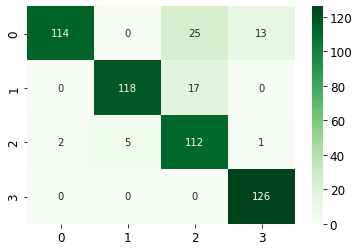

In [9]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,preds)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = np.asarray(group_counts).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

In [10]:
print(metrics.classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9828    0.7500    0.8507       152
           1     0.9593    0.8741    0.9147       135
           2     0.7273    0.9333    0.8175       120
           3     0.9000    1.0000    0.9474       126

    accuracy                         0.8818       533
   macro avg     0.8923    0.8894    0.8826       533
weighted avg     0.8997    0.8818    0.8823       533



Text(0, 0.5, 'PC2')

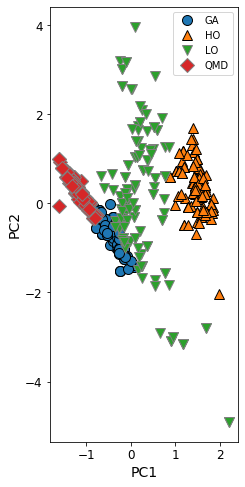

In [11]:
import mglearn

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_test_scaled[:,0], X_test_scaled[:,1], preds)
plt.legend(["GA", "HO", "LO", "QMD"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")